# Using OPCSIM to Build and Model an Optical Particle Counter (OPC)

The following tutorial will show you how a low-cost OPC is represented when using the opcsim software. You will learn how to build a model OPC, how to mimic a calibration for specific aerosols, and how to evaluate the OPC against a simulated aerosol distribution. Visualization tools will also be discussed.

First, we import the python libraries we need and set the styles used for plotting throughout this tutorial.

In [1]:
# Make imports
import opcsim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import seaborn as sns

%matplotlib inline

# turn off warnings temporarily
import warnings
warnings.simplefilter('ignore')

# Let's set some default seaborn settings
sns.set(context='notebook', style='ticks', palette='dark', font_scale=1.75, 
        rc={'figure.figsize': (12,6), **opcsim.plots.rc_log})

print (opcsim.__version__)

0.3.0+14.g8325170


# The OPC Model

The `opcsim.OPC` class provides a simple way to model most of the functionality of low-cost optical particle counters. This model is based on just a few instrument parameters which should be defined in the manufacturer's speficication sheet. 

An OPC is defined by just the laser wavelength (`wl`), the exact `bins` the OPC uses as its output, and the angles for which the scattered light is collected between (`theta`). Other work has considered much more detail that this, including the electrical properties and characteristics of the photodetector, etc. However, this typically requires knowledge or information that is not commonly available in the datasheet of a low-cost particle counter, and thus we try to provide a method that does not rely on this information. 

Within the software itself, there is flexibility in how exactly you define the bins. In the end, you will end up with a 3xn array of values, where n is the number of bins. Each bin is then defined by its left bin boundary, midpoint, and right bin boundary. 
 
To simulate an OPC using the `opcsim.OPC` class, we initiate as follows:

In [2]:
opc = opcsim.OPC(wl=0.658, n_bins=5, theta=(32., 88.))

opc

<class 'opcsim.models.OPC'>

When initiated with no arguments, the default arguments are used and can be looked up in the API documentation. This sets $dmin=0.5\;\mu m$, $dmax=2.5\;\mu m$, and $n_{bins}=5$. We can view the number of bins using the `OPC.n_bins` attribute.

In [3]:
opc.n_bins

5

We can also view the bin boundaries and midpoint diameters using the `OPC.bins` attribute. Here, we receieve a **3xn** array where the first entry is the left bin boundary, the middle is the midpoint diameter as defined by its geometric mean, and the last entry is the right bin boundary.

In [4]:
opc.bins

array([[0.5       , 0.58730947, 0.68986483],
       [0.68986483, 0.8103283 , 0.95182697],
       [0.95182697, 1.11803399, 1.3132639 ],
       [1.3132639 , 1.54258466, 1.81194916],
       [1.81194916, 2.12834981, 2.5       ]])

## Building more specific OPC's

We can build more complex - or specified - models by increasing the number of bins in a couple of ways: (1) we can change the minimum or maximum cutoffs, or the total number of bins:

In [5]:
opc_10bins = opcsim.OPC(wl=0.658, n_bins=10, dmin=0.38, dmax=17.5)

opc_10bins.bins

array([[ 0.38      ,  0.46019969,  0.55732566],
       [ 0.55732566,  0.67495025,  0.81739972],
       [ 0.81739972,  0.98991341,  1.19883643],
       [ 1.19883643,  1.45185303,  1.75826924],
       [ 1.75826924,  2.12935514,  2.57875939],
       [ 2.57875939,  3.12301123,  3.78212839],
       [ 3.78212839,  4.58035343,  5.54704531],
       [ 5.54704531,  6.71775925,  8.13555449],
       [ 8.13555449,  9.85257798, 11.93198238],
       [11.93198238, 14.45024885, 17.5       ]])

If we are trying to model a specific OPC that has pre-defined bins, we can also do that with the help of some utility methods. The bins argument in the OPC class requires a **3xn** array as seen above. Often, you may only have the bin boundary information and not the midpoints. We can define the bins as an array of the bin boundaries, where there are 1 more entries than total number of bins, as follows:

In [6]:
opc = opcsim.OPC(wl=0.658, bins=[0.38, 0.54, 0.78, 1.05, 1.5, 2.5])

opc.bins

array([[0.38      , 0.45299007, 0.54      ],
       [0.54      , 0.64899923, 0.78      ],
       [0.78      , 0.90498619, 1.05      ],
       [1.05      , 1.25499004, 1.5       ],
       [1.5       , 1.93649167, 2.5       ]])

This more or less covers how we can build various OPC's - if you are still unsure of what to do in a specific case, feel free to post questions on the GitHub repository under the 'Issues' tab.

# OPC Calibration

OPC's count and size each particle individualy - the size of a particle is determined by the signal amplitude measured by the photo-detector, which is proportional to the product of the intensity of incoming light and the particle's scattering cross-section. This model assumes light intensity is constant, thus every particle experiences the same light intensity. Assuming this is valid, we can state the size of a particle is proportional ot the scattering cross-section of that particle. 

The output we receieve from an OPC is a histogram with the total number of particles in a specified size bin. So how do we know which bin a given particle belongs to? We must calibrate our OPC and tell it, based on the $C_{scat}$ value, which bin a particle belongs to. While the literature dives deep into complicated, and possibly more accurate ways to do this, we offer three easy methods that can often be found in today's low-cost devices:

  1. `spline` - a simple mapping between $C_{scat}$ and $D_p$
  2. `linear` - fit a power law (linear in log-log space) to the $C_{scat}$ values at every bin boundary
  3. `piecewise` - the same as `linear` except we split into two different curves


### Assumptions we make

  * all particles are spheres
  * light intensity is constant
  * all particles fall squarely within the laser

We will walk through how to calibrate using each approach, but first, let's take a look at a typical scattering pattern for an OPC with a 658 nm laser and a collection angle of 32-88 degrees.

In [14]:
# build a generic OPC with 10-bins
opc = opcsim.OPC(wl=0.658, theta=(32.0, 88.0), n_bins=10)

opc

<class 'opcsim.models.OPC'>

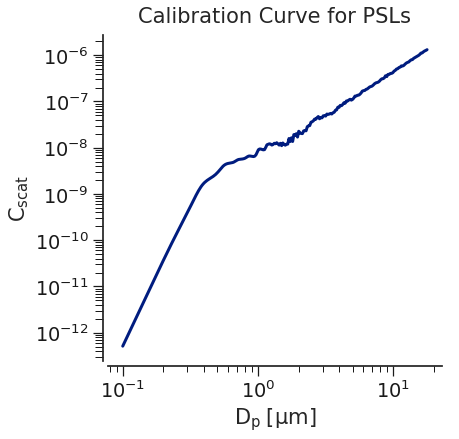

In [8]:
# generate an array of particle diameters
dp = np.logspace(-1, 1.25, 250)
vals = [opcsim.mie.cscat(x, wl=0.658, refr=complex(1.59, 0), theta1=32., theta2=88.) for x in dp]

fig, ax = plt.subplots(1, figsize=(6, 6))

ax.plot(dp, vals, lw=3)

ax.semilogx()
ax.semilogy()

ax.set_title("Calibration Curve for PSLs", y=1.02)
ax.set_xlabel("$D_p\;[\mu m]$")
ax.set_ylabel("$C_{scat}$")

sns.despine(offset=5)

As we can see in the figure above, there are $C_{scat}$ values that are not monotonically increasing as the particle diameter increases, which may make it difficult to assign that value to 1 bin specifically. This is a very well known and documented issue with OPC's and should play a role in choosing bin boundaries. Additionally, it only gets more complicated as the particle optical properties change!

Now, we will examine the two simple approaches to modeling our ways out of this.

## Calibration Method 1: `spline`

One of the most common ways to associate a $C_{scat}$ value with a corresponding particle size is to use spline interpolation. Essentially, this entails evaluating the $C_{scat}$ curve at every bin boundary and grouping all $C_{scat}$ values within range of those two boundaries as belonging to that bin. This work fairly well when the bins are chosen intelligently for a given aerosol type. However, this is not only the case and there are non-monotonically increasing bins from time-to-time. To remove issues associated with this "dips", we implement a solution where we interpolate across any "dips". This is far from perfect, but gives us reasonable results. 

Note that this can make it quite difficult for particles to get assigned to certain bins, especially if the $C_{scat}$ values plateau - this can be somewhat solved by combining these bins into one bin to reduce the uncertainty in bin assignment, though it will make the correct particle sizing in that bin less precise as well.

Note that it is also possible to write your own calibration function, so do not fret!

In [18]:
# calibrate using spline
opc.calibrate("psl", method="spline")

# show the Cscat values corresponding to each bin boundary
opc.calibration_function

functools.partial(<bound method OPC._digitize_opc_bins of <class 'opcsim.models.OPC'>>, cscat_boundaries=array([2.86492750e-09, 4.48206290e-09, 5.25272279e-09, 6.02393845e-09,
       6.64256044e-09, 9.09772227e-09, 1.08326613e-08, 1.25676003e-08,
       1.40492264e-08, 1.99683184e-08, 4.17442631e-08]))

Let's take a look at the calibration:

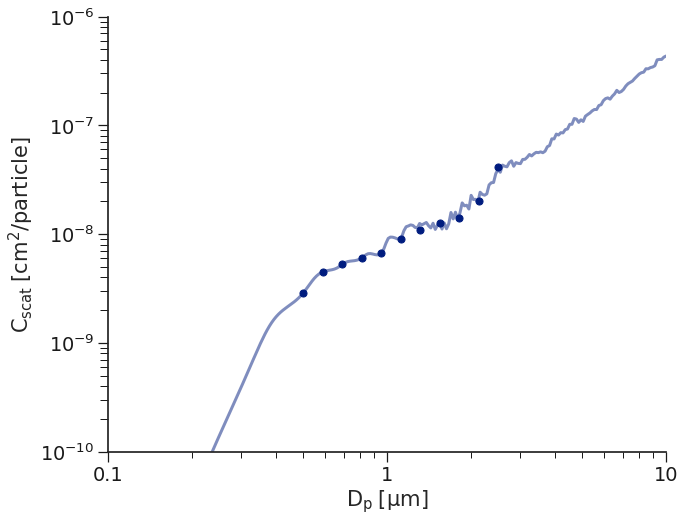

In [25]:
fig, ax = plt.subplots(1, figsize=(10, 8))

ax = opcsim.plots.calplot(opc, ax=ax, dp=np.logspace(-1, 1, 250), plot_kws=dict(alpha=.5))

ax.set_xlim(0.1, 10)
ax.set_ylim(1e-10, 1e-6)

sns.despine()

## Method 2: `linear`

The second approach to generating our map of $C_{scat}$ to $D_p$ values is to fit a line to the data in log-log space. Here, we begin by plotting the bin boundaries on top of the PSL scattering line for an OPC that models the Alphasense OPC-N2.

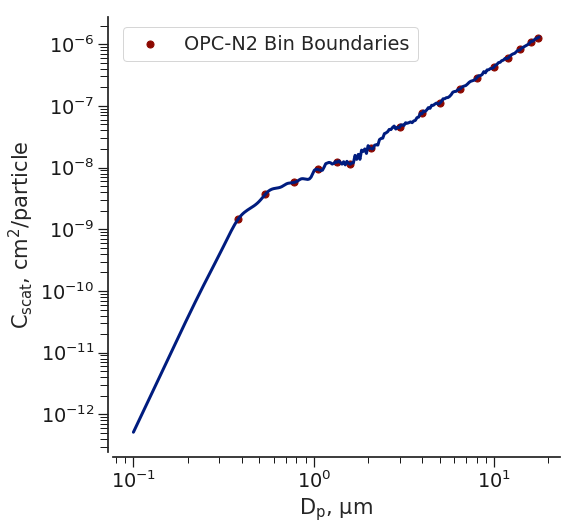

In [13]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(1, figsize=(8, 8))

ax.plot(dp, vals, lw=3)

ax.set_xlabel("$D_p$, $\mu m$")
ax.set_ylabel("$C_{scat}$, $cm^2$/particle")

# draw some bins
f = interp1d(x=dp, y=vals)

bb = np.array([0.38, 0.54, 0.78, 1.05, 1.34, 1.59, 2.07, 3., 4., 
               5., 6.5, 8., 10., 12., 14., 16., 17.5])

ax.scatter(bb, f(bb), color='r', s=50, label="OPC-N2 Bin Boundaries")
ax.legend()

ax.semilogx()
ax.semilogy()

sns.despine(offset=5)

We can fit a line to these data points, which will generate an easy mapping between the two values - however, it will likely undersize particles in some regions and oversize them in others. You can easily create complicated polynomial or machine-learning approaches to matching these values; however, it will all get thrown into chaos when we begin to incorporate particles of various optical properties and morphologies.

## Method 3: `piecewise` linear fit

Similarly, we can fit a `piecewise` linear fit, where there are two linear fits, separated based on the $C_{scat}$ value at a pre-determined breakpoint as defined by the user.

In [50]:
import scipy

def piecewise_linear(x, x0, a1, a2, b1, b2):
    return np.piecewise(x, [x < x0], [
        lambda x: a1*np.power(x, b1),
        lambda x: a2*np.power(x, b2)
    ])

sigma = np.power(10, np.log10(f(bb)) + 1)

p, e = scipy.optimize.curve_fit(piecewise_linear, bb, f(bb), sigma=sigma)

p

array([1.00000000e+00, 9.92135111e-09, 5.82312909e-09, 1.91907065e+00,
       1.87064143e+00])

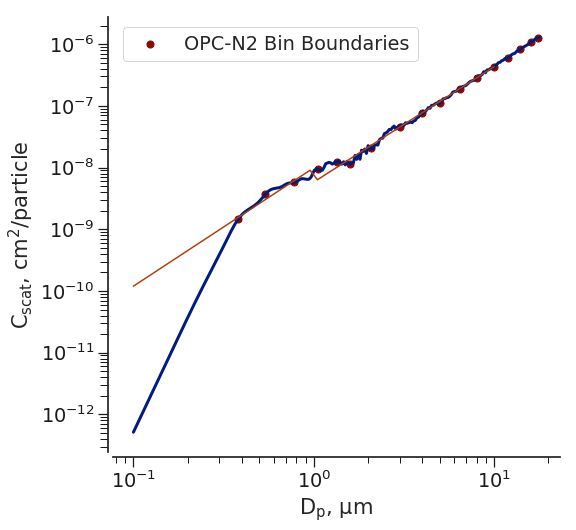

In [52]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.plot(dp, vals, lw=3)

ax.set_xlabel("$D_p$, $\mu m$")
ax.set_ylabel("$C_{scat}$, $cm^2$/particle")

xd = np.logspace(np.log10(.1), np.log10(10), num=50)

ax.plot(xd, piecewise_linear(xd, *p))
# draw some bins
# f = interp1d(x=dp, y=vals)

# bb = np.array([0.38, 0.54, 0.78, 1.05, 1.34, 1.59, 2.07, 3., 4., 
#                5., 6.5, 8., 10., 12., 14., 16., 17.5])

ax.scatter(bb, f(bb), color='r', s=50, label="OPC-N2 Bin Boundaries")
ax.legend()

ax.semilogx()
ax.semilogy()

sns.despine(offset=5)

## So, how do we calibrate our sensor?

It is recommended you begin with one of the two approaches above, which are both built into the `OPC.calibrate` function. Once you get a hang of those, you can go ahead and get more sophisticated.

To calibrate our sensor, we simply define the material we want to use to calibrate. We can define the material in one of two ways: 

  1. you can input a string with the material name
  2. you can input the materials complex refractive index at the wavelength of your device
  
The material lookup table is quite limited and are mostly values taken as close to 658 nm as possible. If you would like to add to this table, please open an issue on GitHub.

### Current Options

| option | Material | Refractive Index |
|:------:|:--------:|:----------------:|
| `psl` | Polystyrene Latex Spheres | 1.592 + 0i |
| `ammonium_sulfate` | Ammonium Sulfate | 1.521 + 0i |
| `sodium_chloride` | Sodium Chloride | 1.5405 + 0i |
| `sodium_nitrate` | Sodium Nitrate | 1.448 + 0i |
| `black_carbon` | Black Carbon | 1.95 + 0.79i |
| `sulfuric_acid` | Sulfuric Acid | 1.427 + 0i |
| `soa` | Secondary Organic Aerosol | 1.4 + 0.002i |
| `urban_high` | High estimate for Urban Aerosol | 1.6 + 0.034i |
| `urban_low` | Low estimate for Urban Aerosol | 1.73 + 0.086i |


To use the method, we simply state the material and the method. We can also get more complicated (check the API docs) if you want to send custom arguments to the fitting function, etc. A simple example would be:

In [14]:
opc.calibrate("psl", method="spline")

opc.calibration_function

functools.partial(<bound method OPC._digitize_opc_bins of <class 'opcsim.models.OPC'>>, cscat_boundaries=array([2.86492750e-09, 4.48206290e-09, 5.25272279e-09, 6.02393845e-09,
       6.64256044e-09, 9.09772227e-09, 1.08326613e-08, 1.25676003e-08,
       1.40492264e-08, 1.99683184e-08, 4.17442631e-08]))

Alternatively, we could calibrate using the linear fit:

In [15]:
opc.calibrate("psl", method="linear")

opc.calibration_function

functools.partial(<bound method OPC._digitize_opc_bins of <class 'opcsim.models.OPC'>>, cscat_boundaries=array([3.12354813e-09, 3.85694293e-09, 4.76253547e-09, 5.88075700e-09,
       7.26153183e-09, 8.96650627e-09, 1.10718009e-08, 1.36714091e-08,
       1.68813933e-08, 2.08450672e-08, 2.57393936e-08]))

When the calibration is executed, it saves the calibration function, which is a digitizer which simply uses the $C_{scat}$ values we computed at each bin boundary during the calibration to return the OPC bin for any given $C_{scat}$ value. If a $C_{scat}$ value is either too high or too low (above or below the boundaries we computed), then it will not assign that particle to a bin."

# Evaluating an OPC for a given Aerosol Distribution

The entire point of this software is to model how various OPC's and other particle sensors "see" aerosols in the real world. The Aerosol Distribution tutorial showed how we can model realistic aerosol distributions. This section will review how the OPC's we just built "see" these distributions. Generally speaking, the process works as follows:

  1. For every particle in the aerosol distribution, we calculate the scattering cross-section
  2. For each of the scattering cross-section's we just calculated, we assign them to a bin of the OPC based on the calibration curve we generated
  3. We end up with a histogram in the form of the cumulative number of particles in each OPC bin, just as we would if we were using a commercially available OPC
  
  
The base method we use to obtain these numbers is `OPC.evaluate`. This method returns the number of particles the OPC "sees" in each bin for a given aerosol distribution. One component that hasn't yet been discussed is how the OPC reacts as relative humidity changes. Each of these methods takes an argument for relative humidity (`rh`) which will automatically calculate the change in particle size due to hygroscopic growth per $\kappa$-kohler theory; the refractive index and density will also change accordingly based on the amount of growth that takes place.

To evaluate a distribution, we need to first define the AerosolDistribution and the OPC.

  * Show examples for a few different scenarios, including growth due to RH
  * show examples for different calibration approaches

In [16]:
# build a single mode of ammonium sulfate
d = opcsim.AerosolDistribution("Amm. Sulfate")

d.add_mode(n=1e3, gm=250e-3, gsd=1.65, kappa=0.53, rho=1.77, refr=complex(1.521, 0))

d

AerosolDistribution: Amm. Sulfate

In [17]:
# build an OPC
opc = opcsim.OPC(wl=0.658, n_bins=24, dmin=0.35, dmax=40.)

opc

<class 'opcsim.models.OPC'>

Let's go ahead and calibrate the OPC using ammonium sulfate:

In [19]:
opc.calibrate("ammonium_sulfate", method="spline")

Now, let's go ahead and evaluate the OPC for the previously defined distribution. This will return the number of particles in each bin:

In [20]:
vals = opc.evaluate(d, rh=0.0)

vals

array([1.05530960e+02, 6.98817010e+01, 3.98414534e+01, 1.95563644e+01,
       7.37540121e+00, 4.02522887e+00, 2.23257552e-01, 5.59489350e-01,
       3.50404796e-01, 3.80044653e-03, 2.12502672e-03, 2.46502814e-04,
       4.80382138e-05, 2.56183671e-06, 5.52369556e-07, 2.62696176e-08,
       1.39596068e-09, 2.41016096e-11, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

## Interating across the Particle Size Distribution

Another important task for evaluation OPC's is comparing the integrated values across some pre-defined particle size range. We can accomplish this by using the `OPC.integrate` method to calculate either the total number of particles, total surface area, total volume, or total mass betweeen any two diameters.

Example:

In [21]:
opc.integrate(d, dmin=0., dmax=2.5, weight='number', rh=0.)

247.34419479917193

In [22]:
opc.integrate(d, dmin=0., dmax=2.5, weight='number', rh=85.)

479.06078758408

## Visualizing the OPC Histogram

Last, it is fairly useful and important for us to be able to easily visualize our results. There are functions built-in to compute the histogram to use with `opcsim.plots.histplot` to easily plot the particle size distribution.

Let's go ahead and visualize our results from earlier:

In [22]:
# compute the histogram
lb, data1, ddp = opc.histogram(d, weight="number", base="log10", rh=0.0)
lb, data2, ddp = opc.histogram(d, weight="number", base="log10", rh=95.0)

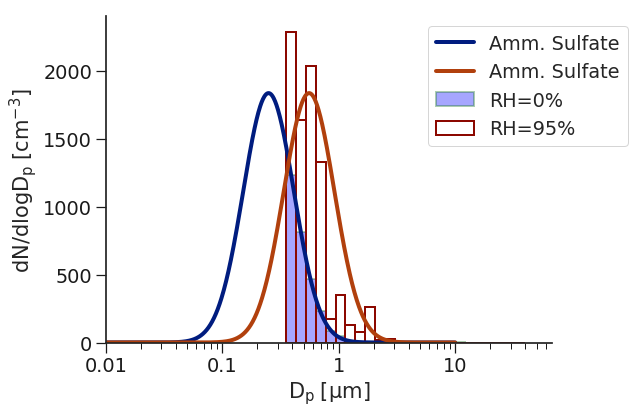

In [23]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax = opcsim.plots.pdfplot(d, ax=ax, weight="number")
ax = opcsim.plots.pdfplot(d, ax=ax, weight="number", rh=95.0)
ax = opcsim.plots.histplot(data=data1, bins=opc.bins, ax=ax, label="RH=0%", 
                           plot_kws=dict(linewidth=2, fill=True, alpha=.35, color='blue'))
ax = opcsim.plots.histplot(data=data2, bins=opc.bins, ax=ax, label="RH=95%", 
                           plot_kws=dict(linewidth=2))

ax.set_ylim(0, None)
ax.set_xlim(0.01, None)
ax.legend(bbox_to_anchor=(.7, 1))

sns.despine()

On the left, we have the PDF of the particle size distribution at 0% RH in dark blue with the histogram, as seen by the OPC, in light blue. In dark red, we have the PDF of the particle size distribution at 95% RH - as you can see, it has shifted right substantially. There is also the histogram, shown as red boxes, of how the OPC "see's" the size distribution at 95% RH. Interestingly, you see the lower part of the distribution (below around 600 nm) simply moves right; however, above that point, the bin assignments start to get screwy. This is due to the Mie Resonance taking hold and making it hard to assign the $C_{scat}$ value to the correct bin.

## Classifying Bin Misassignment

One way to gain an underestanding of how reliable/accurate the OPC is is to estimate the range of bins particles of a specific size could be assigned to. For example, if we calibrated our OPC with Ammonium Sulfate at 0% RH, and then only evaluated Ammonium Sulfate at that same RH, we would be fairly confident in our ability to resolve the correct bin. However, if we suddenly were in a more humid environment, how would we do? 

There are a fwe `metrics` methods available by default to help understand the expected range of bin assignments - each is detailed below.

### `compute_bin_assessment`

The objective of this method is to assess the ability of an OPC to assign particles to the correct bin. It uses a calibrated OPC to evaluate a material of some refractive index and kappa value at various relative humidities. The method returns a dataframe containing data including: the correct bin assignment, the lower estimate for bin assignment, the upper estimate for bin assignment, the effective refractive index, the relative humidity, and the lower and upper limit's of scattered light to expected scattered light.

Our primary focus here is estimating the effects of changes in relative humidity, which (1) causes the aerosols to grow as they uptake water and (2) causes the refractive index to change.

In [26]:
rv = opcsim.metrics.compute_bin_assessment(opc, refr=complex(1.521, 0), kappa=0.53)

rv

,bin_true,bin_lo,bin_hi,refr_eff,rh,cscat_hi_ratio,cscat_lo_ratio
0,0,0,1,(1.521+0j),0.0,1.000000,1.000000
1,1,1,2,(1.521+0j),0.0,1.000000,1.000000
2,2,2,3,(1.521+0j),0.0,1.000000,1.000000
3,3,3,4,(1.521+0j),0.0,1.000000,1.000000
4,4,4,5,(1.521+0j),0.0,1.000000,1.000000
5,5,5,6,(1.521+0j),0.0,1.000000,1.000000
6,6,6,8,(1.521+0j),0.0,1.000000,1.000000
7,7,8,8,(1.521+0j),0.0,1.000000,1.000000
8,8,8,9,(1.521+0j),0.0,1.000000,1.000000
9,9,9,10,(1.521+0j),0.0,1.000000,1.000000


Above, we see that when RH is low and their is little growth or change in refractive index, we mostly do a great job of assigning particles to the correct bin. However, when the RH increases substantially and significant watre uptake occurs, the combination of massive growth in the actual particle size, along with the substantial change in refractive index, leads to massive oversizing which will have large effects when converting from number distribution to volume and/or mass distribution.